<a href="https://colab.research.google.com/github/Grystniu/U-net-restoration/blob/main/U_NET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install unrar

In [ ]:
!unrar x /content/wl/wl.rar

In [ ]:
import os
os.remove('/content/wl/wl.rar')

In [ ]:
import sys
sys.path.append('/content/modules.py')

In [ ]:
from modules import *

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

def U_Net(input_size, input_channels, filters, learning_rate):
    X = Input(shape=(input_size, input_size, input_channels))

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(X)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up4 = Concatenate()([UpSampling2D(size=(2, 2))(conv3), conv2])
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = Concatenate()([UpSampling2D(size=(2, 2))(conv4), conv1])
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv5)

    model = Model(inputs=X, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

In [ ]:
path2 = '/content/result3N'
path = '/content/result4'
train_set_X, train_set_Y, val_set_X, val_set_Y, test_set_X, test_set_Y = read_data(path, path2)

In [ ]:
unet = U_Net(input_size=128, input_channels=1, filters=64, learning_rate=0.001)
history = unet.fit(x=train_set_X, y=train_set_Y, validation_data=(val_set_X, val_set_Y), batch_size=32, epochs=15)

13/13 [==============================] - 3s 200ms/step
average SSIM of U-Net on the testing set: 0.9466017484664917


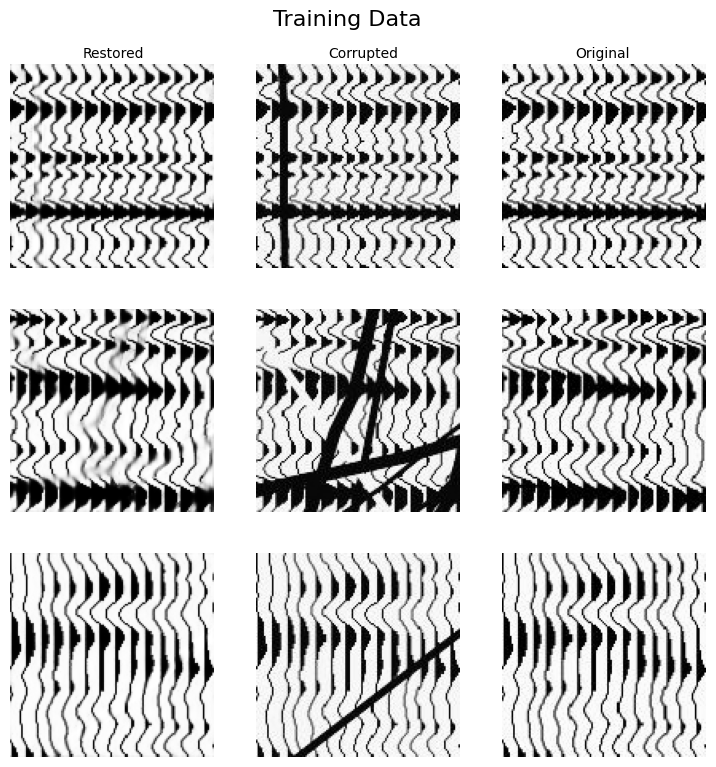

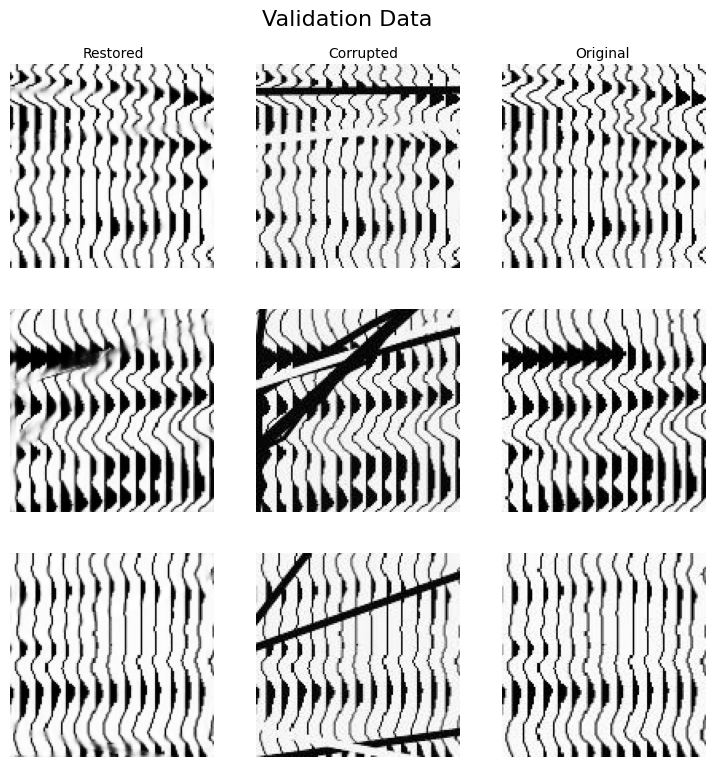

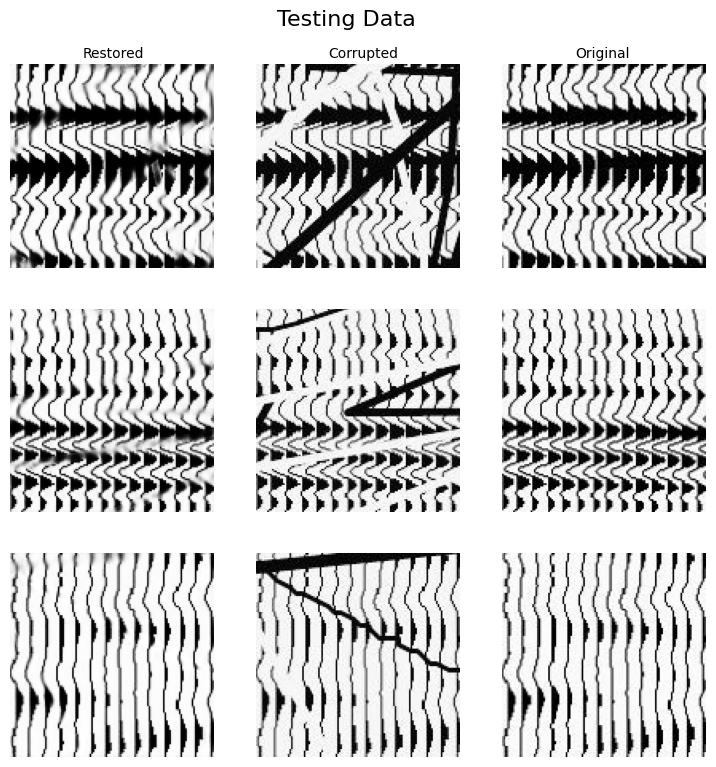

In [ ]:
import tensorflow as tf
y_pred = unet.predict(test_set_X)
print('average SSIM of U-Net on the testing set: {}'.format(tf.math.reduce_mean(tf.image.ssim(test_set_Y, y_pred, 1.)).numpy()))
# print few results of outputs of the U-Net on the training set
print_model_outputs(unet, train_set_X[:4], train_set_Y[:4], 'Training Data')

# print few results of outputs of the U-Net on the validation set
print_model_outputs(unet, val_set_X[:4], val_set_Y[:4], 'Validation Data')

# print few results of outputs of the model on the testing set
print_model_outputs(unet, test_set_X[:4], test_set_Y[:4], 'Testing Data')

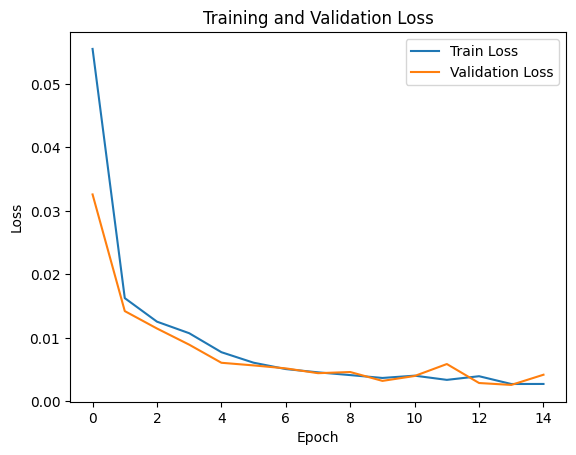

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
My_pred1 = read_single_image('/content/testXXXX')

In [ ]:
Origin = read_single_image('/content/testYYYY')

In [ ]:
My_predictions = unet.predict(My_pred1)

In [ ]:
print('average SSIM of U-Net on the testing set: {}'.format(tf.math.reduce_mean(tf.image.ssim(Origin, My_predictions, 1.)).numpy()))

In [ ]:

# print few results of outputs of the U-Net on the training set
print_model_outputs(unet, My_pred1, Origin, 'New_prediction')

In [ ]:
from tensorflow.keras.models import model_from_json

def save_unet(model, model_name="unet"):
    # Сохранение архитектуры модели в формате JSON
    model_json = model.to_json()
    with open(f"{model_name}.json", "w") as json_file:
        json_file.write(model_json)

    # Сохранение весов модели
    model.save_weights(f"{model_name}_weights.h5")
    print(f"Модель {model_name} успешно сохранена.")

def load_unet(model_name="unet"):
    # Загрузка архитектуры модели из JSON
    with open(f"{model_name}.json", "r") as json_file:
        loaded_model_json = json_file.read()
        loaded_model = model_from_json(loaded_model_json)

    # Загрузка весов модели
    loaded_model.load_weights(f"{model_name}_weights.h5")
    print(f"Модель {model_name} успешно загружена.")

    return loaded_model

In [ ]:
load = load_unet()

Модель unet успешно загружена.


In [ ]:
import tensorflow as tf
My_pred1 = read_single_image('/content/testXXXX')
Origin = read_single_image('/content/testYYYY')
My_predictions = load.predict(My_pred1)
print('average SSIM of U-Net on the testing set: {}'.format(tf.math.reduce_mean(tf.image.ssim(Origin, My_predictions, 1.)).numpy()))

In [ ]:
print_model_outputs(load, My_pred1, Origin, 'New_prediction')

In [ ]:
source_folder = '/content/wl'
destination_folder = '/content/wlresult'

In [ ]:
from PIL import Image
import numpy as np
import os

def read_single_image_and_save(path, save_path, model=None):
    processed_images = []

    for file_name in os.listdir(path):
        file_path = os.path.join(path, file_name)
        if os.path.isfile(file_path):
            # Чтение и изменение размера изображения
            image = Image.open(file_path).resize((128, 128))
            image = np.asarray(image)

            # Преобразование цветного изображения в оттенки серого, если необходимо
            if len(image.shape) > 2:
                image = np.dot(image[..., :3], [0.2989, 0.587, 0.114])

            # Нормализация значений пикселей к диапазону [0, 1]
            max_val, min_val = image.max(), image.min()
            image = (image - min_val) / (max_val - min_val)

            # Предсказание, если передана модель
            if model is not None:
                prediction = model(np.expand_dims(image, axis=(0, -1)).astype('float32'), training=False)
                processed_images.append(prediction[0, :, :, 0])

                # Сохранение предсказанного изображения
                save_prediction_path = os.path.join(save_path, f"{file_name}")
                save_prediction = Image.fromarray((prediction[0, :, :, 0] * 255).numpy().astype('uint8'))
                save_prediction.save(save_prediction_path)
            else:
                processed_images.append(image)

            # Сохранение обработанного изображения
            # save_file_path = os.path.join(save_path, file_name)
            # save_image = Image.fromarray((image * 255).astype('uint8'))
            # save_image.save(save_file_path)

    # Преобразование списка изображений в массив и добавление размерности
    return np.expand_dims(processed_images, axis=-1).astype('float32')


# Передайте вашу обученную модель в параметр model
model = load
processed_images = read_single_image_and_save(source_folder, destination_folder, model=model)

In [ ]:
import os
import shutil

# Указываем путь к папке с вашими изображениями
source_folder = '/content/wlresult'

# Создаем временную папку для архива
temp_folder = '/content/temp_archive'
os.makedirs(temp_folder, exist_ok=True)

# Копируем изображения во временную папку
for file_name in os.listdir(source_folder):
    file_path = os.path.join(source_folder, file_name)
    if os.path.isfile(file_path):
        shutil.copy(file_path, temp_folder)

# Создаем архив
shutil.make_archive('/content/temp_archive', 'zip', temp_folder)

print("Архив создан.")

# Перемещаем архив в нужное место (если необходимо)
shutil.move('/content/temp_archive.zip','/content/temp_archive.zip' )

# Очищаем временную папку
shutil.rmtree(temp_folder)

Архив создан.
